In [1]:
import os
import json

import numpy
import matplotlib
from matplotlib import pyplot

from discohisto import (
    fit_normal,
    fit_cabinetry,
    fit_cabinetry_post,
    fit_linspace,
    fit_mcmc_mix,
    fit_mcmc_tfp_ham,
    region,
)

In [2]:
def plot_fits(
    region_name,
    cabinetry_class=fit_cabinetry.FitCabinetry,
    cabinetry_post_class=fit_cabinetry_post.FitCabinetryPost,
    normal_class=fit_normal.FitNormal,
    linspace_class=fit_linspace.FitLinspace,
):
    print(region_name)
    path = os.path.join(BASENAME, region_name, "fit")
    
    region_i = region.Region.load(os.path.join(BASENAME, region_name))
    n_region = _get_n_region(region_i)
    
    n_reported = REPORTED[region_name]["n"]
    mismatch = ", !!!!!!!!!!!!!!" * (n_region != n_reported)
    print("n = %d (%d%s)" % (n_reported, n_region, mismatch))
    
    bkg = REPORTED[region_name]["bkg"]
    bkg_hi = REPORTED[region_name]["bkg_hi"]
    bkg_lo = REPORTED[region_name]["bkg_lo"]
    
    cabinetry = cabinetry_class.load(path)
    cabinetry_post = cabinetry_post_class.load(path)
    normal = normal_class.load(path)
    linspace = linspace_class.load(path)
    # disgusting hack TODO
    mcmc = None
    for mcmc_class in [fit_mcmc_mix.FitMcmcMix, fit_mcmc_tfp_ham.FitMcmcTfpHam]:
        try:
            mcmc = mcmc_class.load(path)
        except FileNotFoundError:
            ...
    assert mcmc is not None
    
    figure, axis = pyplot.subplots(tight_layout=(0, 0, 0))
    
    # TODO split to functions
    # TODO normalize to area, not maximum
    
    # plot reported
    axis.plot(
        [bkg + bkg_hi, bkg + bkg_lo],
        [-5] * 2,
        color="xkcd:barney purple",
        linewidth=2,
    )
    axis.scatter(
        [bkg], 
        [-5],
        s=10 ** 2,
        color="xkcd:barney purple",
        marker="*",
        linewidth=2,
        facecolor="w",
        zorder=2.2
    )
    
    # plot cabinetry bar
    axis.plot(
        [
            cabinetry.yield_pre - cabinetry.error_pre, 
            cabinetry.yield_pre + cabinetry.error_pre,
        ],
        [-4] * 2,
        color="xkcd:mahogany",
        linewidth=2,
    )
    axis.scatter(
        [cabinetry.yield_pre], 
        [-4],
        s=10 ** 2,
        color="xkcd:mahogany",
        marker="o",
        linewidth=2,
        facecolor="w",
        zorder=2.2
    )
    
    axis.plot(
        [
            cabinetry_post.yield_post - cabinetry_post.error_post, 
            cabinetry_post.yield_post + cabinetry_post.error_post,
        ],
        [-4.5] * 2,
        color="xkcd:green",
        linewidth=2,
    )
    axis.scatter(
        [cabinetry_post.yield_post], 
        [-4.5],
        s=10 ** 2,
        color="xkcd:green",
        marker="o",
        linewidth=2,
        facecolor="w",
        zorder=2.2
    )
    
    # plot normal bar
    axis.plot(
        [
            normal.yield_linear - normal.error_linear, 
            normal.yield_linear + normal.error_linear,
        ],
        [-3] * 2,
        "k",
        linewidth=2,
    )
    axis.scatter(
        [normal.yield_linear], 
        [-3],
        s=10 ** 2,
        color="k",
        marker="D",
        linewidth=2,
        facecolor="w",
        zorder=2.2
    )
    
    # plot linspace
    linspace_y = _linspace_density(linspace)
    linspace_x = numpy.linspace(linspace.start, linspace.stop, len(linspace.levels))
    pyplot.plot(
        linspace_x, 
        _safe_log(linspace_y),
        "b",
        linewidth=2,
    )
    
    # plot mcmc
    mcmc_y = _mcmc_density(mcmc, 50)
    mcmc_x = numpy.linspace(*mcmc.range_, len(mcmc_y))
    pyplot.plot(
        mcmc_x,
        _safe_log(mcmc_y),
        "r",
        linewidth=2,
        drawstyle="steps-post",
    )

    xmin = min(linspace.start, mcmc.range_[0])
    xmax = max(linspace.stop, mcmc.range_[1])
    pyplot.xlim(xmin, xmax)
    pyplot.ylim(-8, 0.5)
    
    pyplot.show()
    
    
def _rebin(array, len_new):
    return numpy.reshape(array, (len_new, -1)).sum(axis=-1)

    
def _safe_log(x):
    is_zero = x == 0
    return numpy.where(
        is_zero,
        -numpy.inf,
        numpy.log(x + is_zero),
    )

def _get_n_region(reg):
    sr_name = reg.signal_region_name
    observations = reg.workspace

    for obs in reg.workspace["observations"]:
        if obs["name"] == sr_name:
            return obs["data"][0]

    raise ValueError(sr_name)


def _linspace_density(linspace):
    levels = numpy.array(linspace.levels)
    y = numpy.exp(levels.min() - levels)
    norm = numpy.trapz(y, dx=(linspace.stop - linspace.start) / (len(levels) - 1))
    return y / norm


def _mcmc_density(mcmc, nbins):
    y = _rebin(mcmc.yields, nbins)
    norm = y.sum() * ((mcmc.range_[1] - mcmc.range_[0]) / nbins)
    y = y / norm
    return numpy.append(y, y[-1])

In [3]:
def load_reported():
    path = os.path.join(BASENAME, "reported.json")
    with open(path) as file_:
        reported = json.load(file_)
    return reported

In [4]:
def main(search):
    # disgusting hack TODO
    global BASENAME, REPORTED
    
    BASENAME = f"/home/tombs/Cambridge/interval-evidence/searches/{search}/"
    REPORTED = load_reported()
    
    print("#", search)
    for sr_name in REPORTED:
        try:
            plot_fits(sr_name)
        except FileNotFoundError as e:
            print("!!! missing", sr_name, e)

# atlas_susy_1Lbb_2020
SR_LM_disc
n = 34 (34)


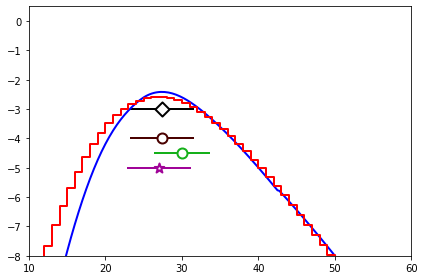

SR_MM_disc
n = 13 (13)


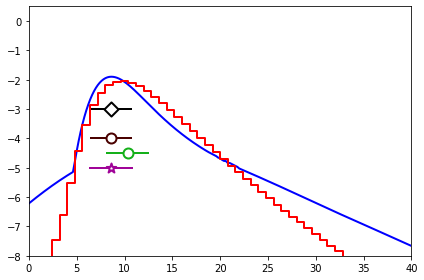

SR_HM_disc
n = 14 (14)


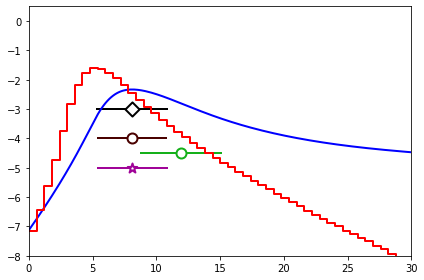

In [5]:
main("atlas_susy_1Lbb_2020")

# atlas_susy_1Ljets_2021
SR2JBVEM_meffInc30_gluino
n = 22 (22)


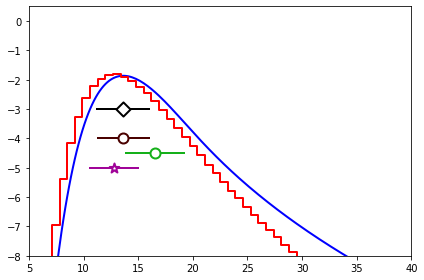

SR2JBVEM_meffInc30_squark
n = 106 (106)


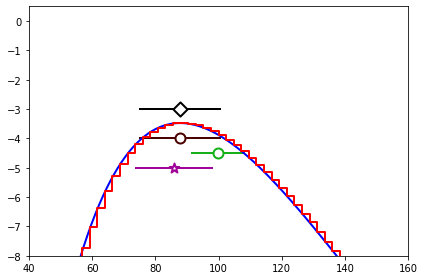

SR4JhighxBVEM_meffInc30
n = 11 (11)


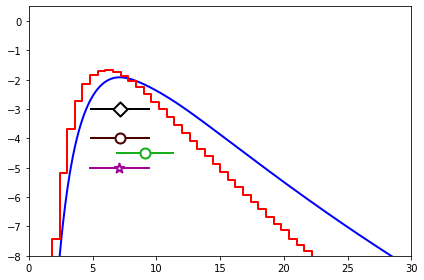

SR4JlowxBVEM_meffInc30
n = 10 (10)


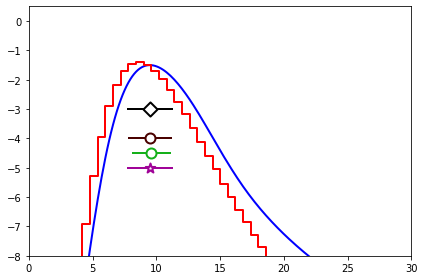

SR6JBVEM_meffInc30_gluino
n = 2 (2)


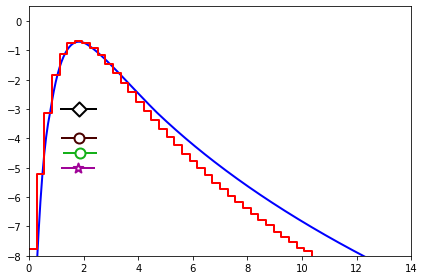

SR6JBVEM_meffInc30_squark
n = 5 (5)


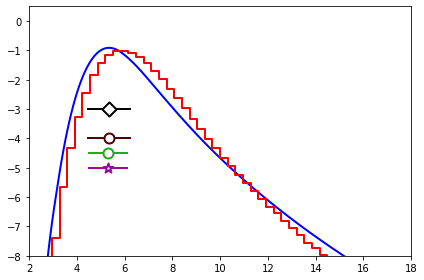

In [6]:
main("atlas_susy_1Ljets_2021")

# atlas_susy_2hadtau_2020
SRlowMass
n = 10 (10)


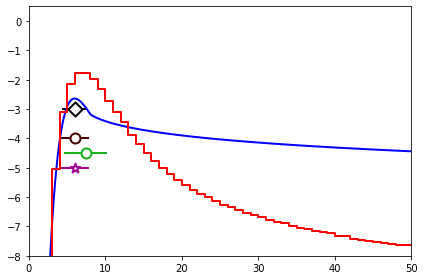

SRhighMass
n = 7 (7)


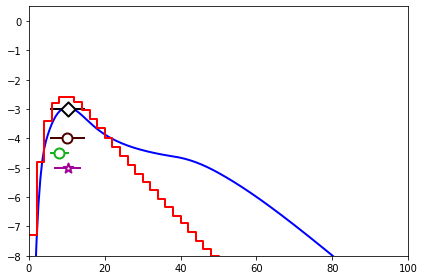

In [7]:
main("atlas_susy_2hadtau_2020")

# atlas_susy_2L0J_2019
SR_DF_0J_100_inf
n = 95 (95)


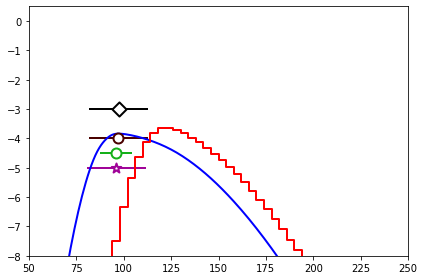

SR_DF_0J_160_inf
n = 21 (21)


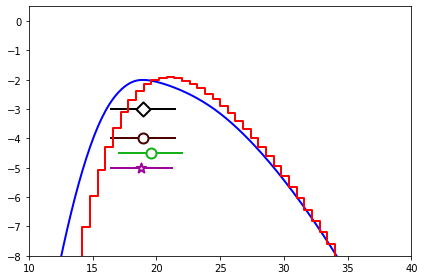

SR_DF_0J_100_120
n = 47 (47)


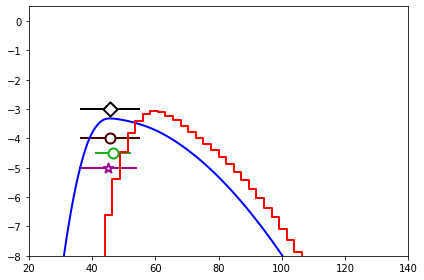

SR_DF_0J_120_160
n = 27 (27)


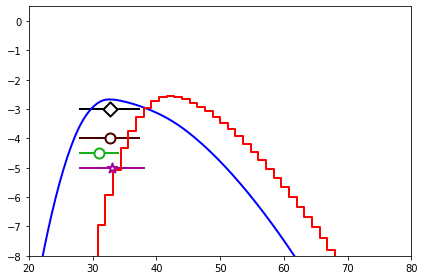

SR_DF_1J_100_inf
n = 75 (75)


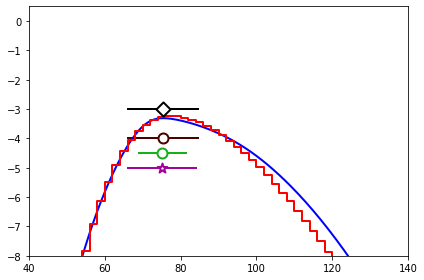

SR_DF_1J_160_inf
n = 15 (15)


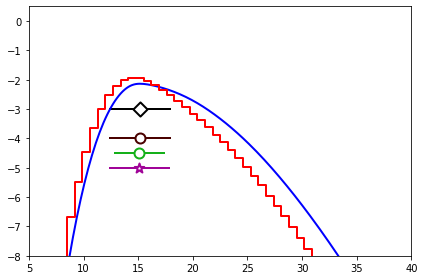

SR_DF_1J_100_120
n = 38 (38)


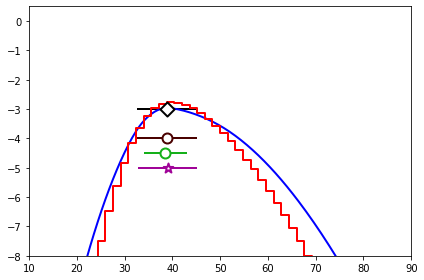

SR_DF_1J_120_160
n = 22 (22)


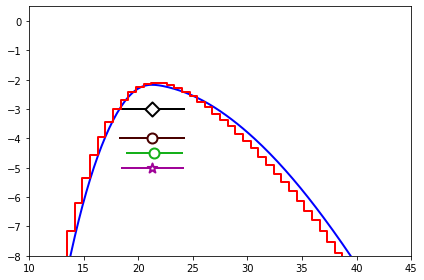

SR_SF_0J_100_inf
n = 147 (147)


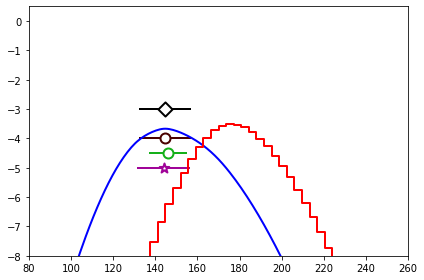

SR_SF_0J_160_inf
n = 37 (37)


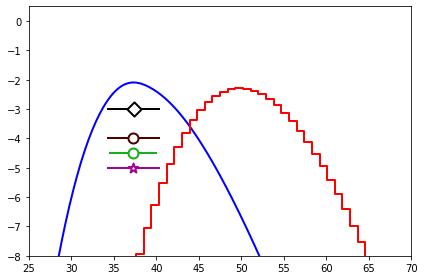

SR_SF_0J_100_120
n = 53 (53)


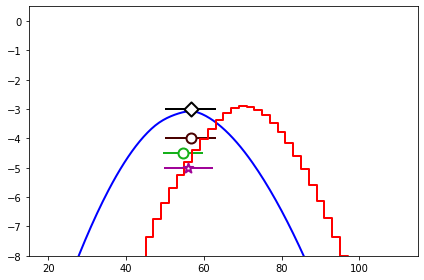

SR_SF_0J_120_160
n = 57 (57)


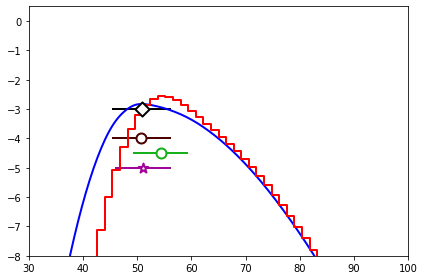

SR_SF_1J_100_inf
n = 120 (120)


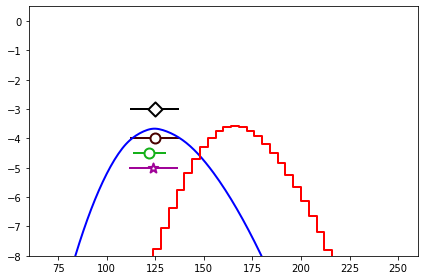

SR_SF_1J_160_inf
n = 29 (29)


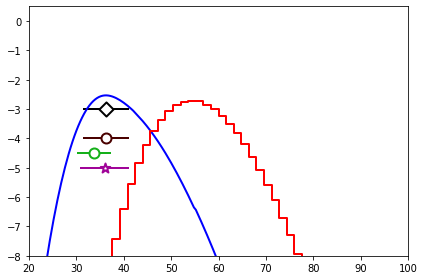

SR_SF_1J_100_120
n = 55 (55)


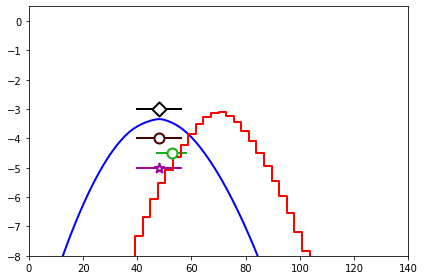

SR_SF_1J_120_160
n = 36 (36)


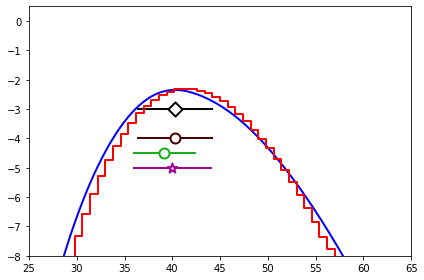

In [8]:
main("atlas_susy_2L0J_2019")

# atlas_susy_2Ljets_2022
rjr_sr2l_low
n = 39 (39)


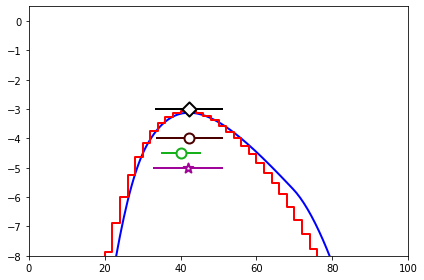

rjr_sr2l_isr
n = 30 (30)


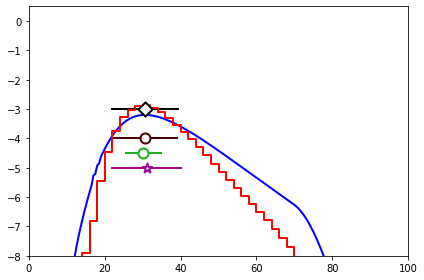

ewk_offshell
n = 21 (21)


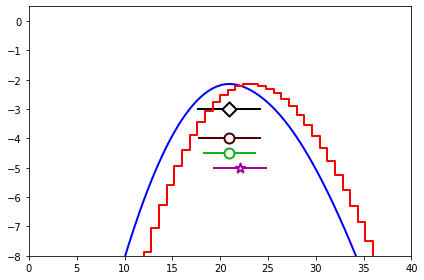

ewk_low
n = 18 (18)


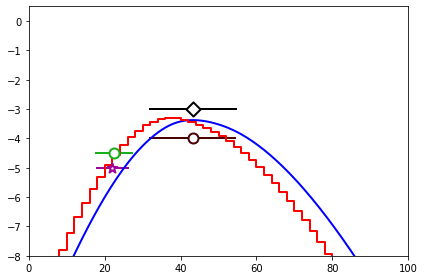

ewk_int
n = 38 (38)


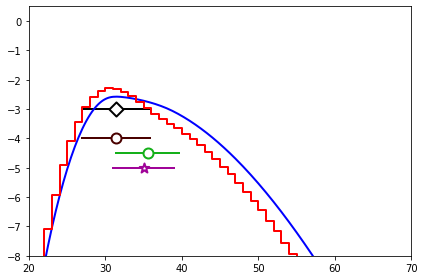

ewk_high
n = 0 (0)


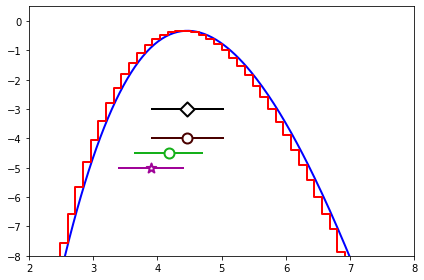

ewk_llbb
n = 0 (0)


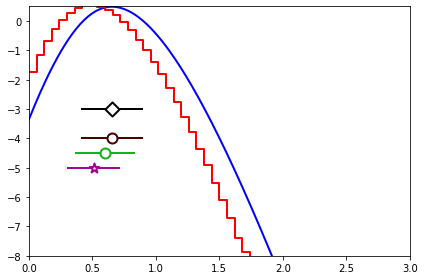

str_src_12_31
n = 2 (2)


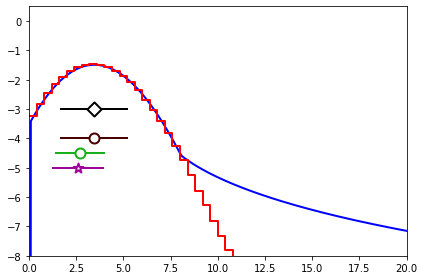

str_src_12_61
n = 7 (7)


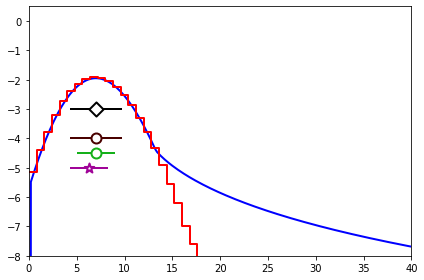

str_src_31_81
n = 9 (9)


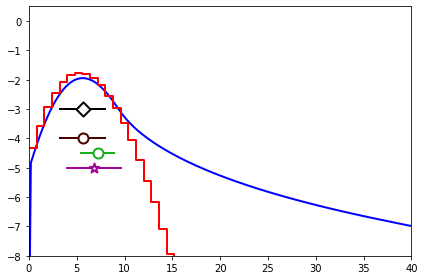

str_src_81
n = 27 (27)


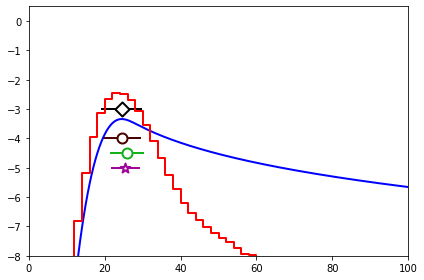

str_srlow_12_81
n = 18 (18)


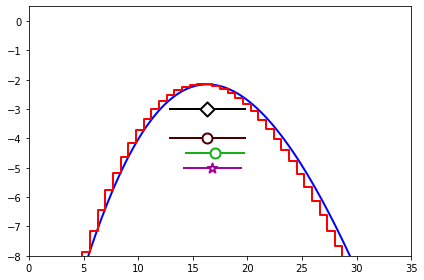

str_srlow_101_201
n = 13 (13)


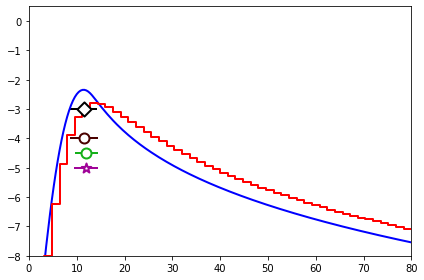

str_srlow_101_301
n = 20 (20)


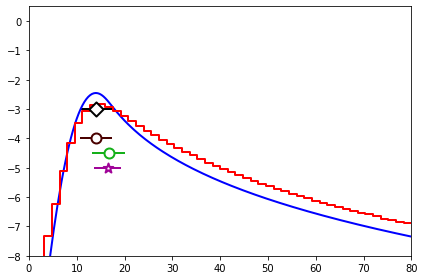

str_srlow_301
n = 6 (6)


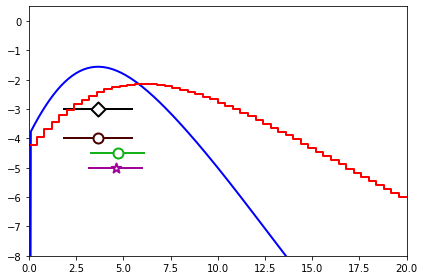

str_srmed_12_101
n = 38 (38)


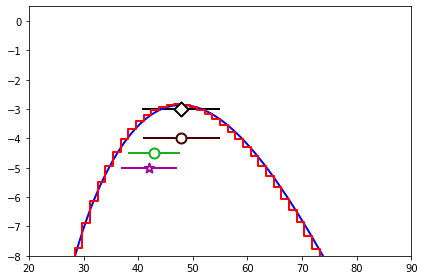

str_srmed_101
n = 27 (27)


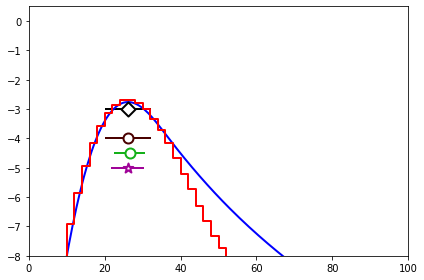

str_srhigh_12_301
n = 18 (18)


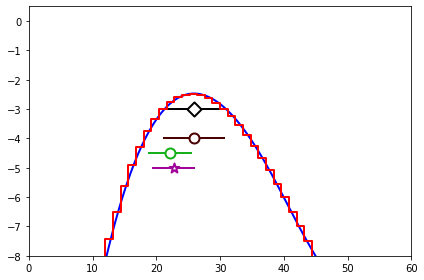

str_srhigh_301
n = 1 (1)


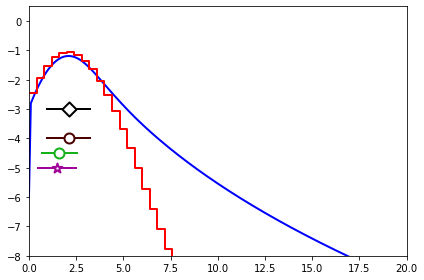

str_srzlow
n = 35 (35)


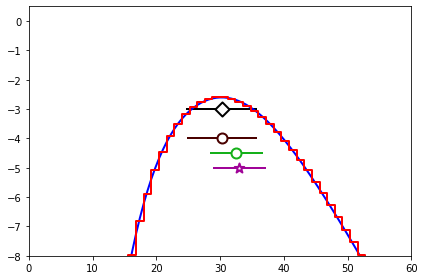

str_srzmed
n = 15 (15)


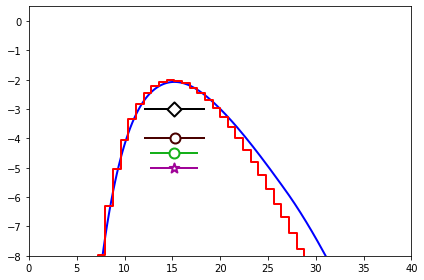

str_srzhigh
n = 3 (3)


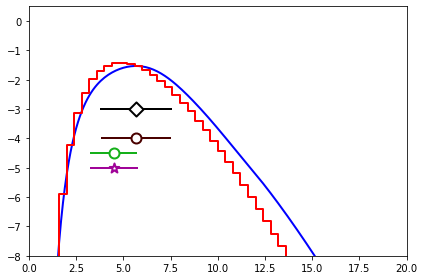

In [9]:
main("atlas_susy_2Ljets_2022")

# atlas_susy_3L_2021
incSR_WZ_1
n = 34 (34)


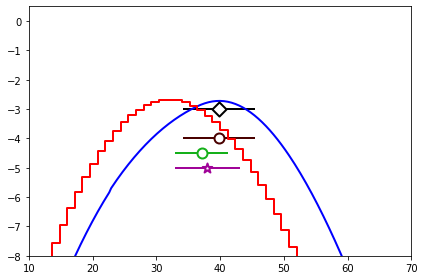

incSR_WZ_2
n = 2 (2)


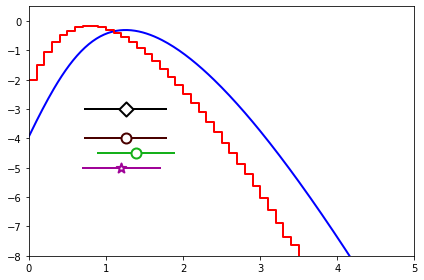

incSR_WZ_3
n = 4 (4)


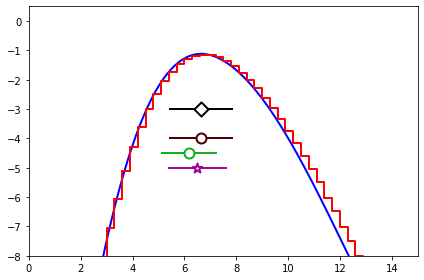

incSR_offWZ_highEt_nj_a
n = 3 (3)


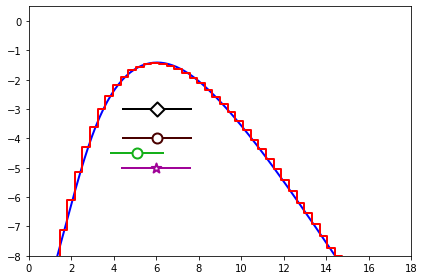

incSR_offWZ_highEt_nj_b
n = 2 (2)


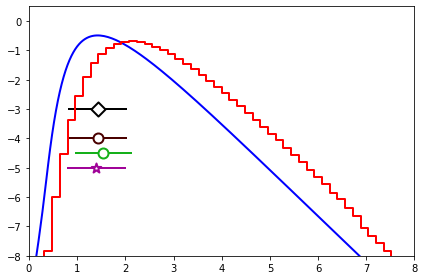

incSR_offWZ_highEt_nj_c1
n = 7 (7)


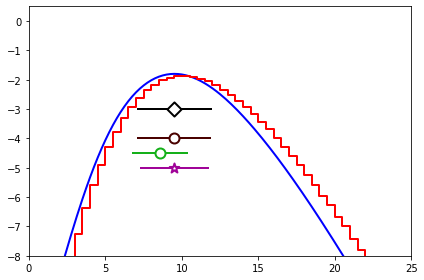

incSR_offWZ_highEt_nj_c2
n = 2 (2)


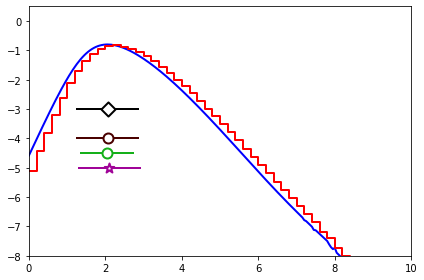

incSR_offWZ_lowEt_b
n = 31 (31)


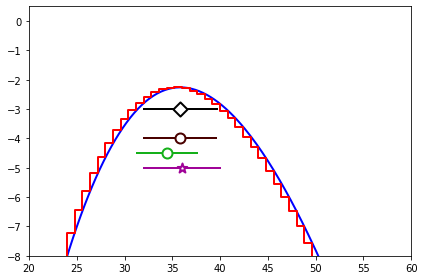

incSR_offWZ_highEt_b
n = 3 (3)


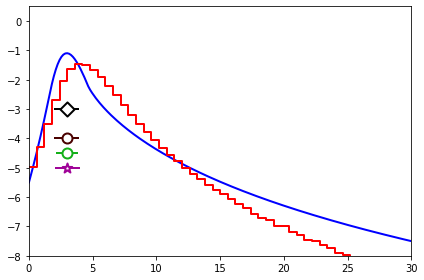

incSR_offWZ_lowEt_c
n = 86 (86)


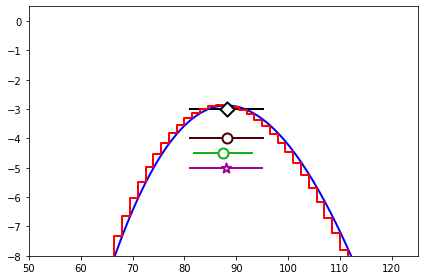

incSR_offWZ_highEt_c
n = 9 (9)


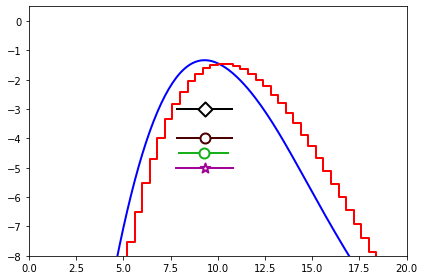

incSR_offWZ_d
n = 202 (202)


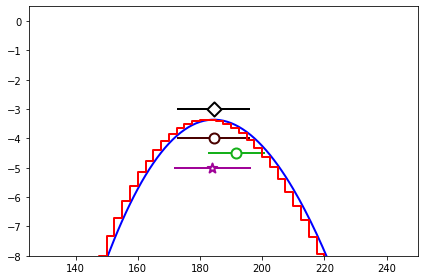

incSR_offWZ_e1
n = 332 (332)


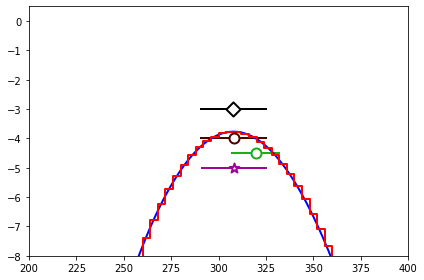

incSR_offWZ_e2
n = 298 (298)


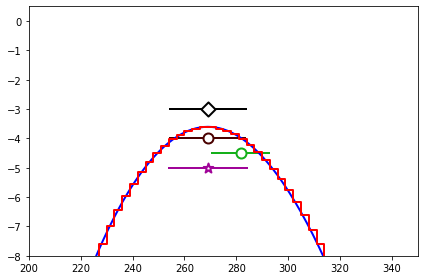

incSR_offWZ_f1
n = 479 (479)


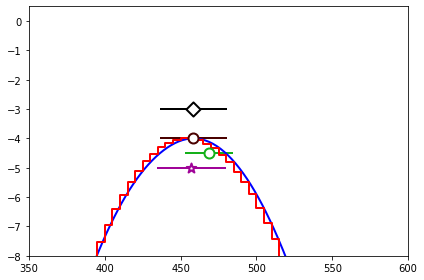

incSR_offWZ_f2
n = 277 (277)


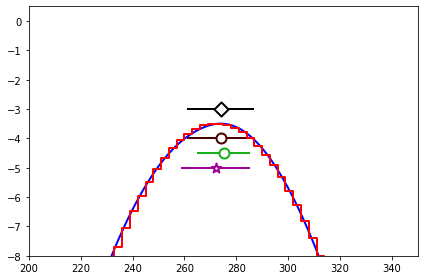

incSR_offWZ_g1
n = 620 (620)


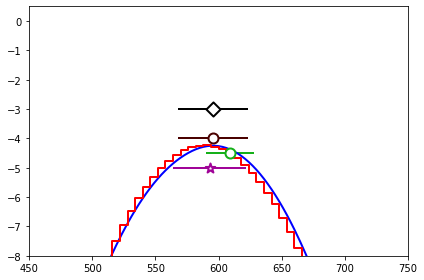

incSR_offWZ_g2
n = 418 (418)


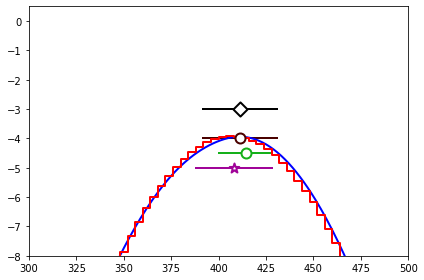

incSR_offWZ_g3
n = 288 (288)


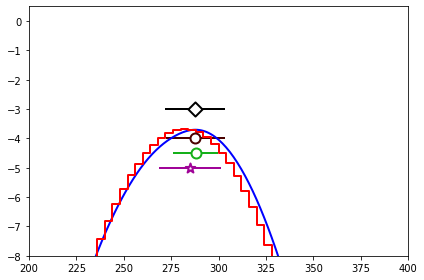

incSR_offWZ_g4
n = 141 (141)


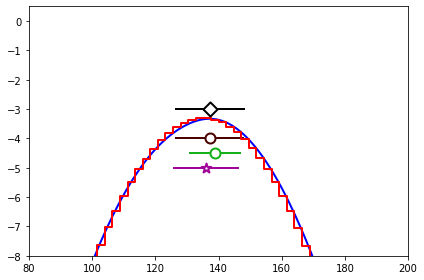

In [10]:
main("atlas_susy_3L_2021")

# atlas_susy_3Lresonance_2020
SRFR_90_110_all
n = 2 (2)


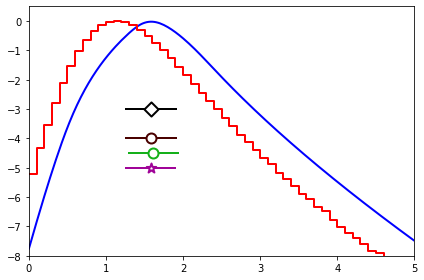

SRFR_110_130_all
n = 5 (5)


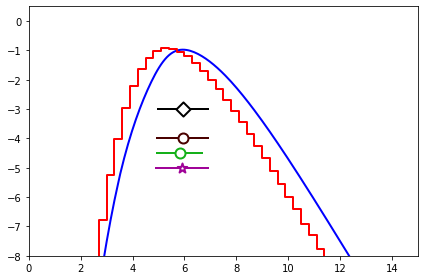

SRFR_130_150_all
n = 2 (2)


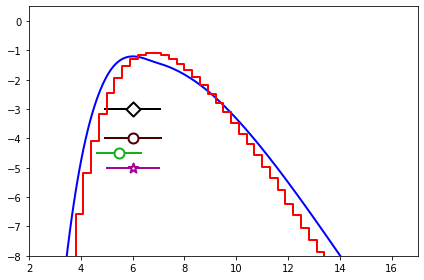

SRFR_150_170_all
n = 12 (12)


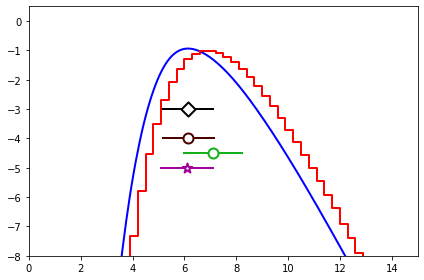

SRFR_170_190_all
n = 5 (5)


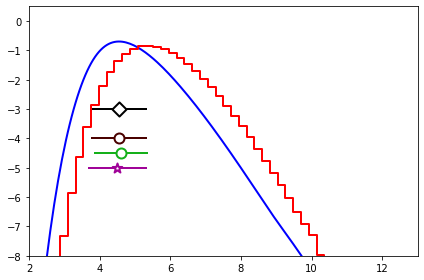

SRFR_190_210_all
n = 4 (4)


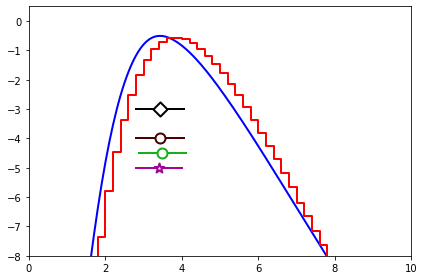

SRFR_210_230_all
n = 2 (2)


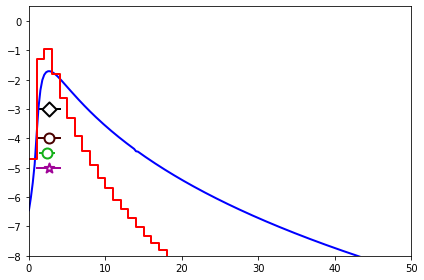

SRFR_230_250_all
n = 2 (2)


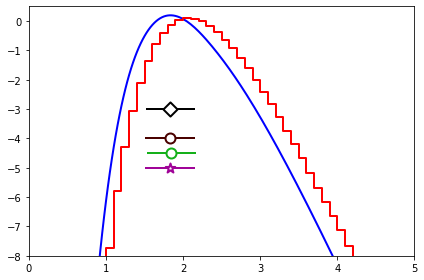

SRFR_250_270_all
n = 1 (1)


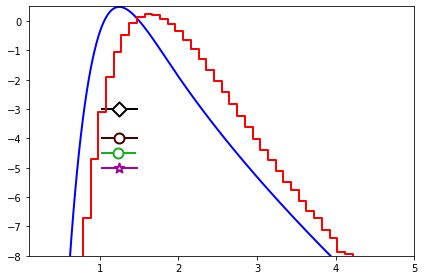

SRFR_270_300_all
n = 0 (0)


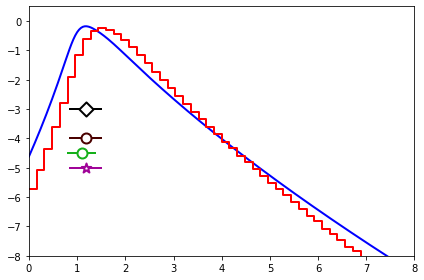

SRFR_300_330_all
n = 3 (3)


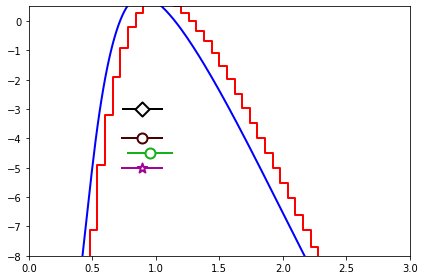

SRFR_330_360_all
n = 2 (2)


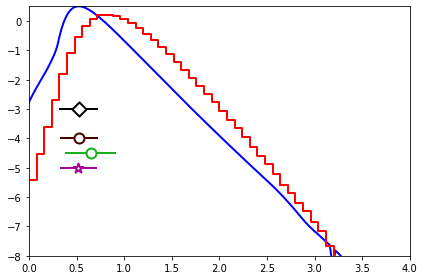

SRFR_360_400_all
n = 1 (1)


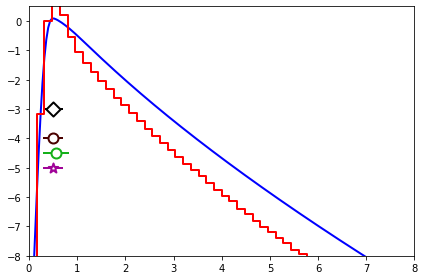

SRFR_400_440_all
n = 0 (0)


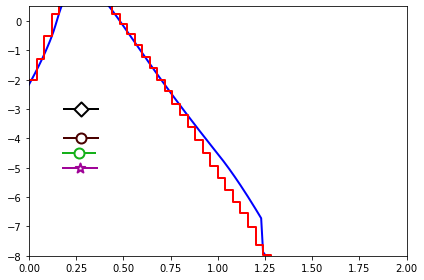

SRFR_440_580_all
n = 1 (1)


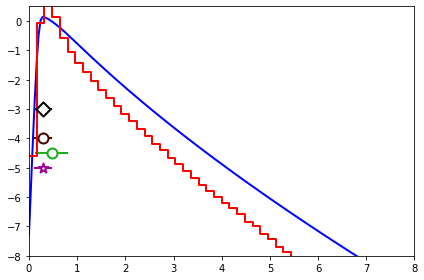

SRFR_580_inf_all
n = 0 (0)


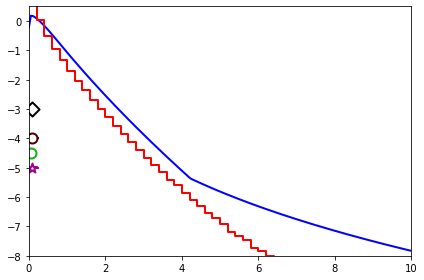

SR4l_90_110_all
n = 9 (9)


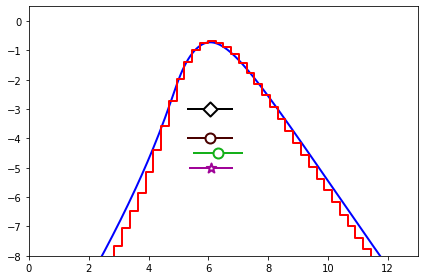

SR4l_110_130_all
n = 22 (22)


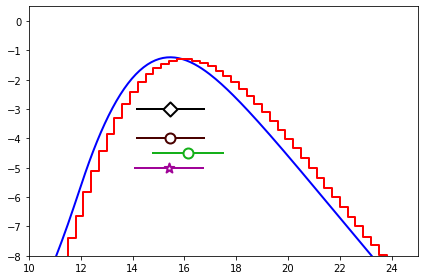

SR4l_130_150_all
n = 15 (15)


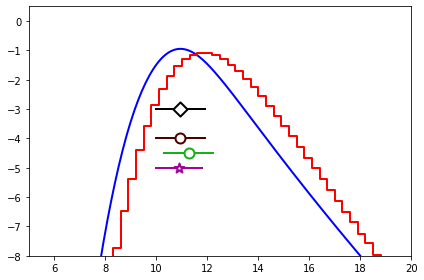

SR4l_150_170_all
n = 10 (10)


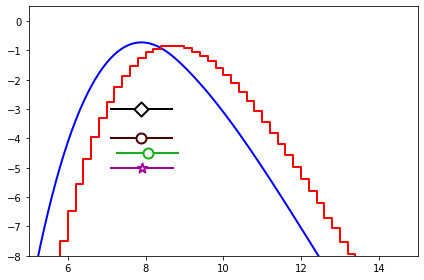

SR4l_170_190_all
n = 12 (12)


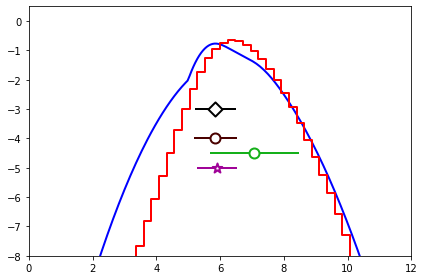

SR4l_190_210_all
n = 7 (7)


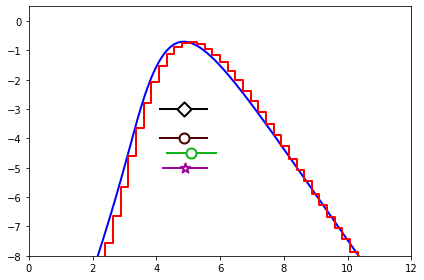

SR4l_210_230_all
n = 2 (2)


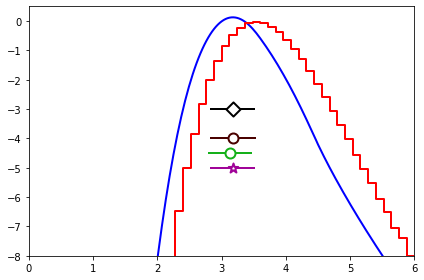

SR4l_230_250_all
n = 2 (2)


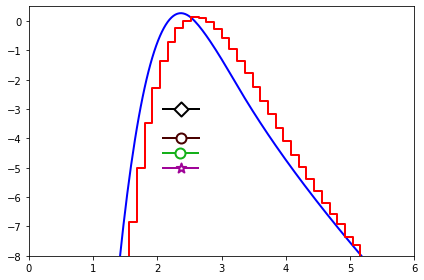

SR4l_250_270_all
n = 2 (2)


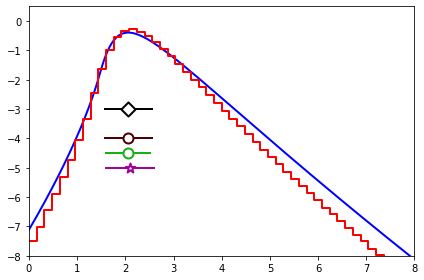

SR4l_270_300_all
n = 2 (2)


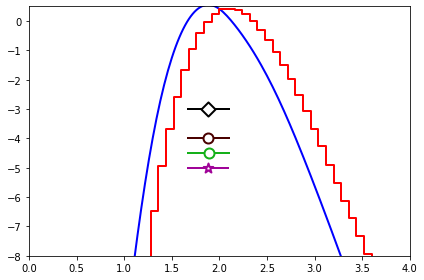

SR4l_300_330_all
n = 1 (1)


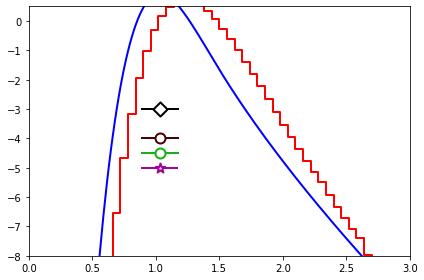

SR4l_330_360_all
n = 1 (1)


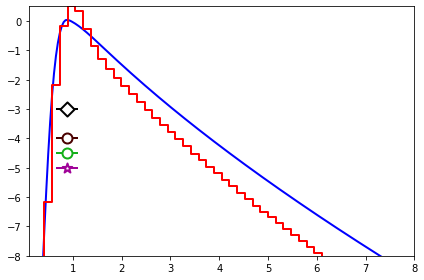

SR4l_360_400_all
n = 0 (0)


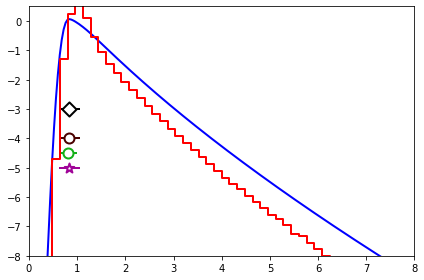

SR4l_400_440_all
n = 1 (1)


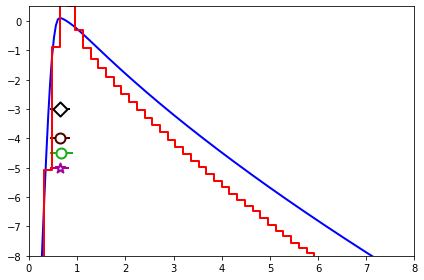

SR4l_440_580_all
n = 2 (2)


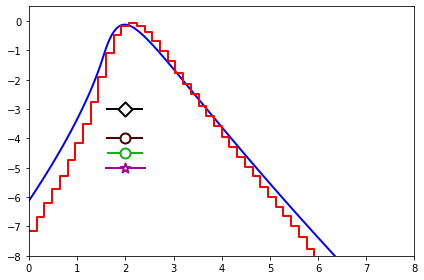

SR4l_580_inf_all
n = 1 (1)


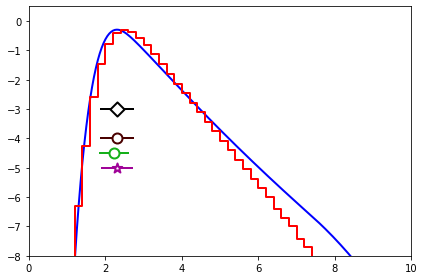

SR3l_90_110_all
n = 0 (0)


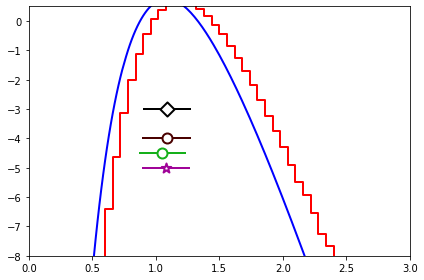

SR3l_110_130_all
n = 5 (5)


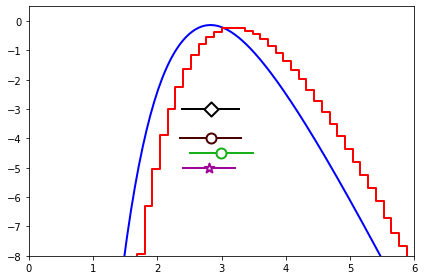

SR3l_130_150_all
n = 5 (5)


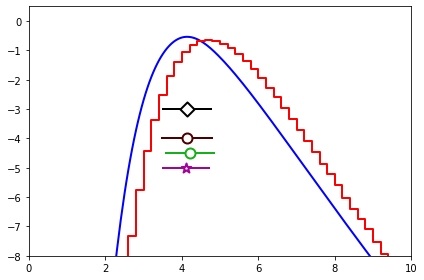

SR3l_150_170_all
n = 2 (2)


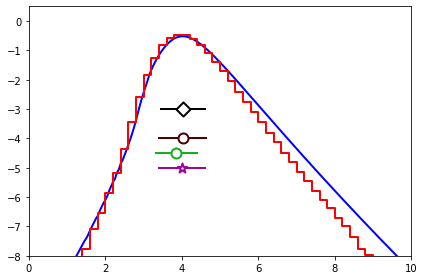

SR3l_170_190_all
n = 3 (3)


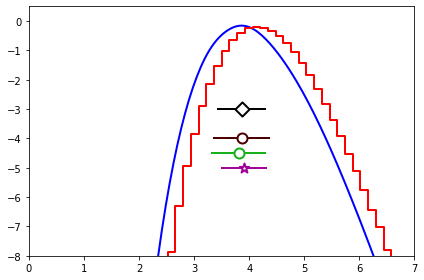

SR3l_190_210_all
n = 7 (7)


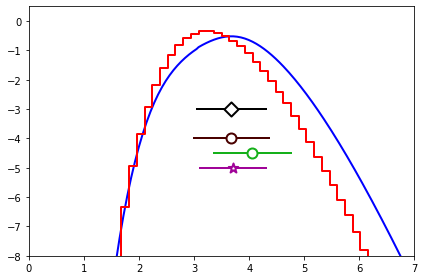

SR3l_210_230_all
n = 6 (6)


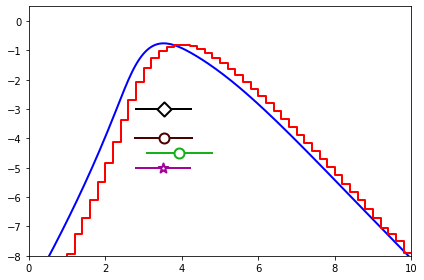

SR3l_230_250_all
n = 4 (4)


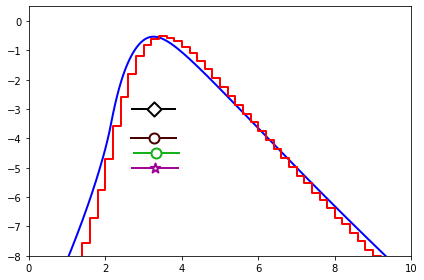

SR3l_250_270_all
n = 3 (3)


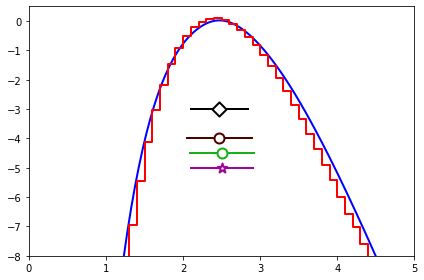

SR3l_270_300_all
n = 3 (3)


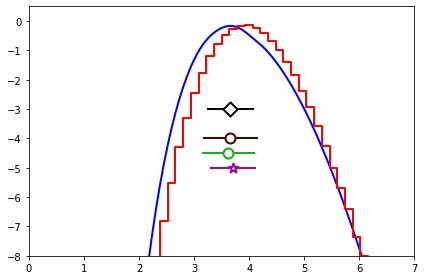

SR3l_300_330_all
n = 3 (3)


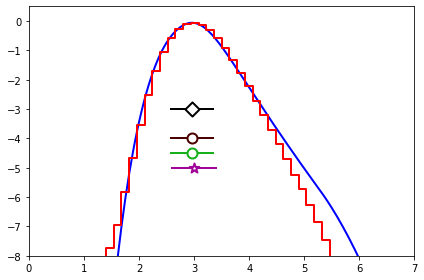

SR3l_330_360_all
n = 2 (2)


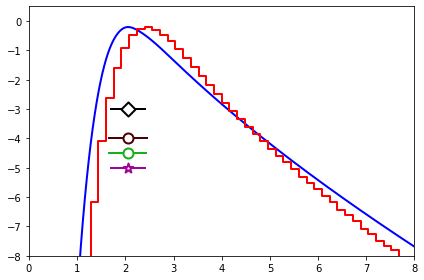

SR3l_360_400_all
n = 3 (3)


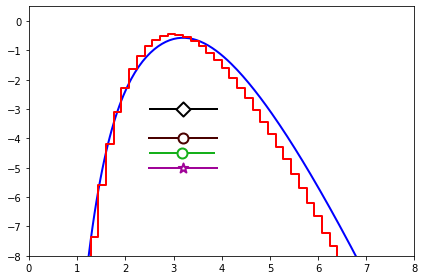

SR3l_400_440_all
n = 0 (0)


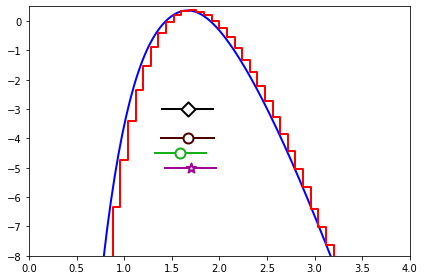

SR3l_440_580_all
n = 7 (7)


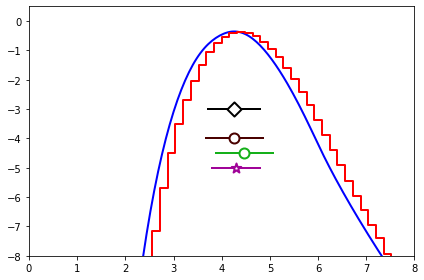

SR3l_580_inf_all
n = 8 (8)


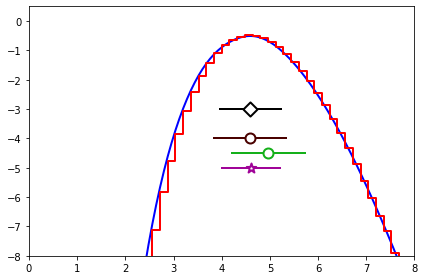

In [11]:
main("atlas_susy_3Lresonance_2020")

# atlas_susy_3LRJmimic_2020
SRlow
n = 51 (51)


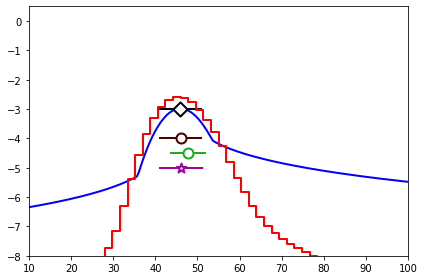

SRISR
n = 30 (30)


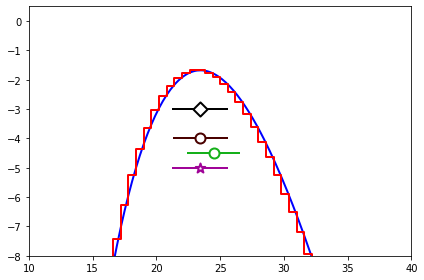

In [12]:
main("atlas_susy_3LRJmimic_2020")

# atlas_susy_3Lss_2019
Rpc2L0b
n = 6 (6)


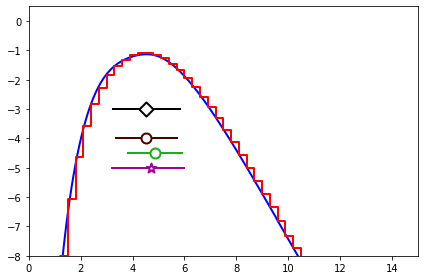

Rpc2L1b
n = 11 (11)


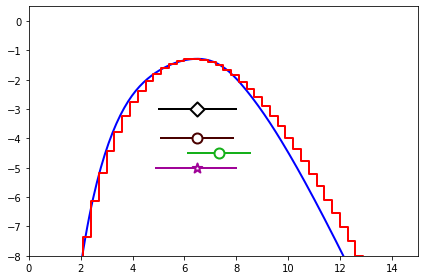

Rpc2L2b
n = 12 (12)


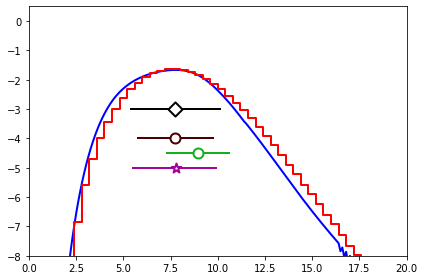

Rpc3LSS1b
n = 4 (4)


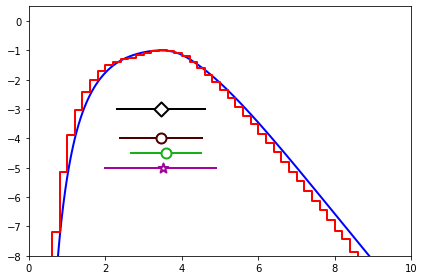

Rpv2L
n = 5 (5)


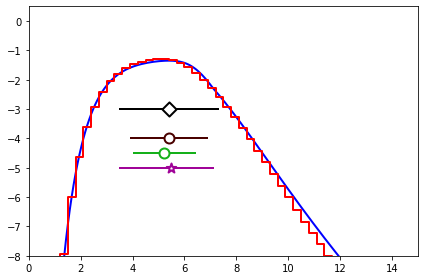

In [13]:
main("atlas_susy_3Lss_2019")

# atlas_susy_4L_2021
SR0ZZloose
n = 157 (157)


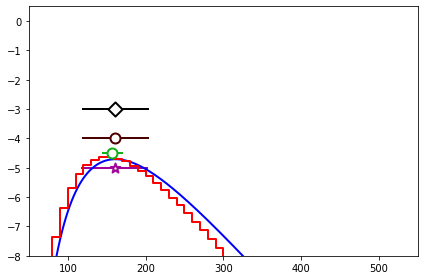

SR0ZZtight
n = 17 (17)


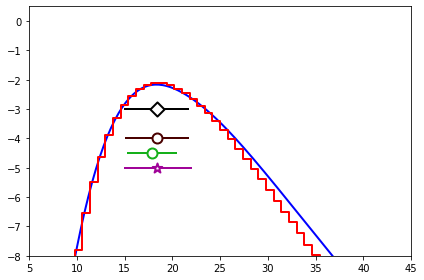

SR0ZZbvetoloose
n = 5 (5)


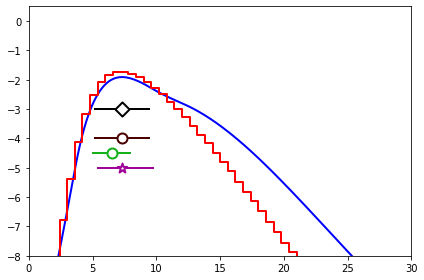

SR0ZZbvetotight
n = 1 (1)


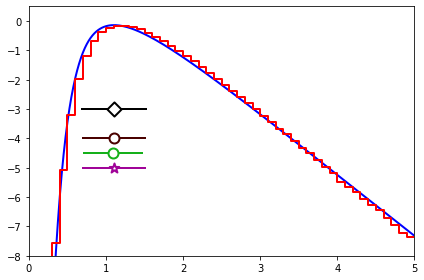

SR0bvetoloose
n = 11 (11)


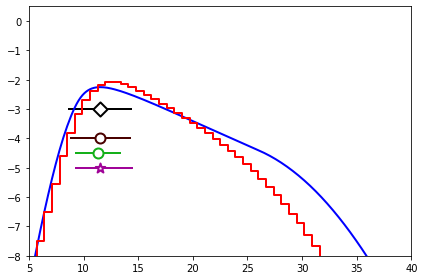

SR0bvetotight
n = 1 (1)


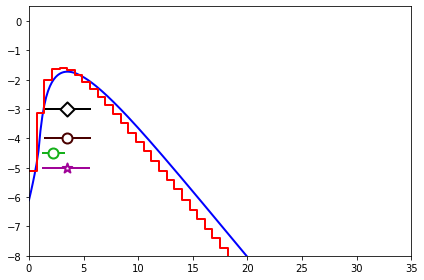

SR0breq
n = 3 (3)


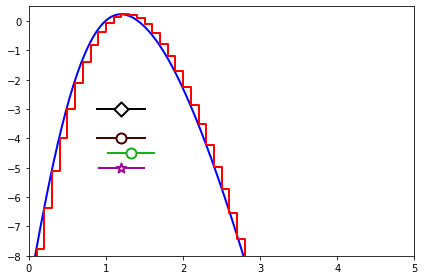

SR1bvetoloose
n = 7 (7)


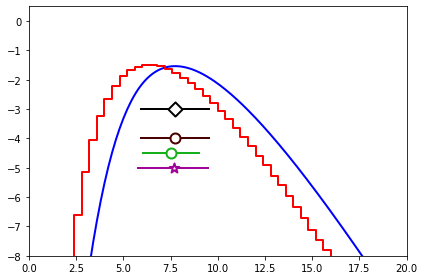

SR1bvetotight
n = 2 (2)


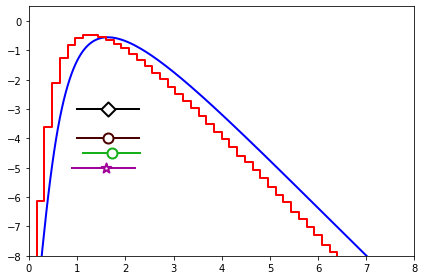

SR1breq
n = 2 (2)


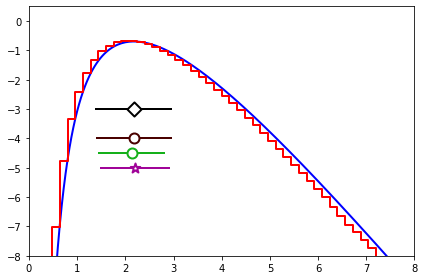

SR2bvetoloose
n = 5 (5)


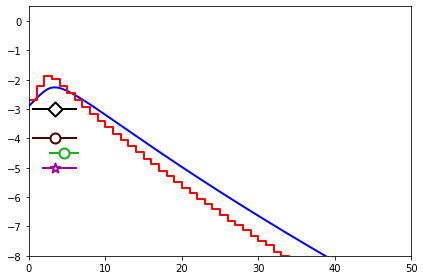

SR2bvetotight
n = 2 (2)


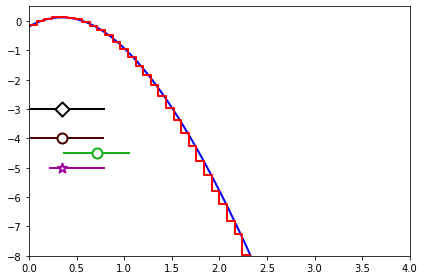

SR2breq
n = 1 (1)


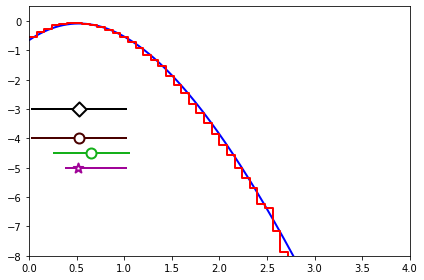

In [14]:
main("atlas_susy_4L_2021")

# atlas_susy_compressed_2020
SR_E_mll_1
n = 0 (0)


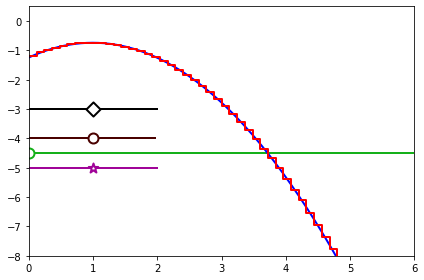

SR_E_mll_2
n = 46 (46)


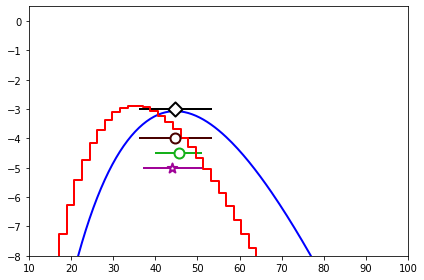

SR_E_mll_3
n = 90 (90)


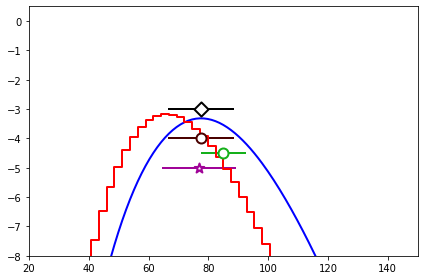

SR_E_mll_5
n = 151 (151)


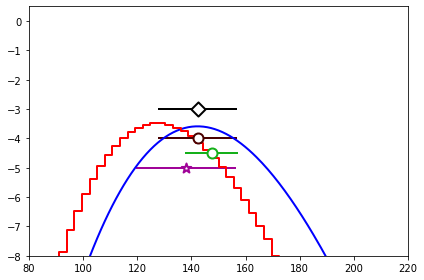

SR_E_mll_10
n = 244 (244)


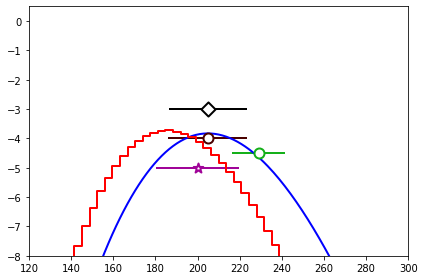

SR_E_mll_20
n = 383 (383)


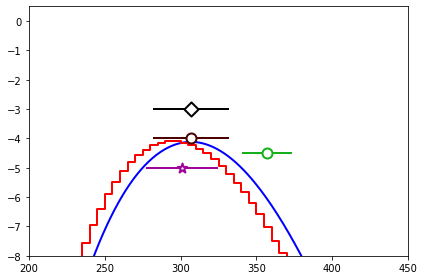

SR_E_mll_30
n = 453 (453)


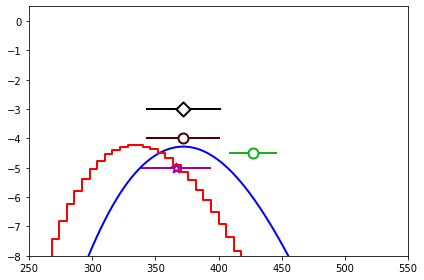

SR_E_mll_40
n = 492 (492)


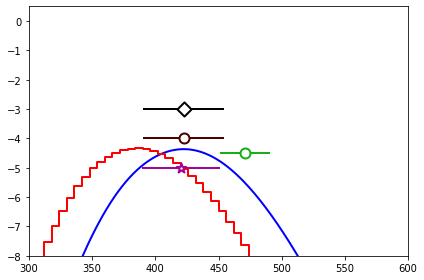

SR_E_mll_60
n = 583 (583)


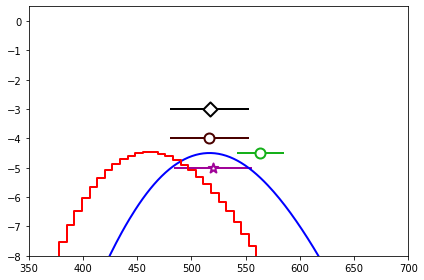

SR_S_100p5
n = 24 (24)


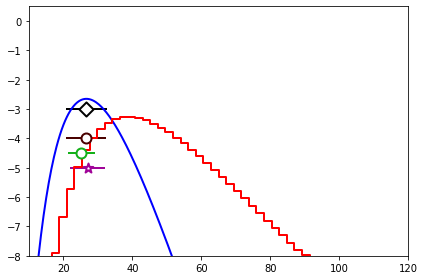

SR_S_101
n = 41 (41)


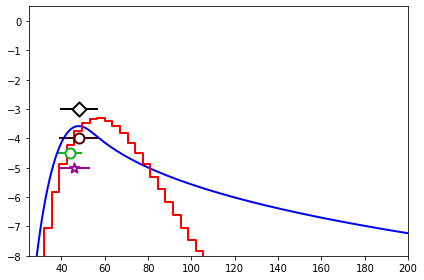

SR_S_102
n = 91 (91)


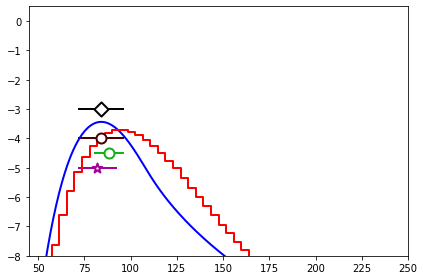

SR_S_105
n = 158 (158)


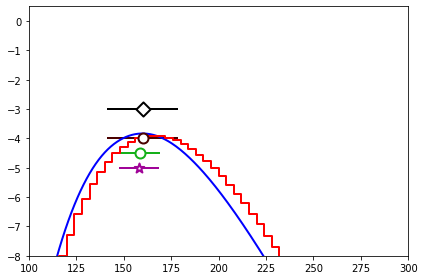

SR_S_110
n = 243 (243)


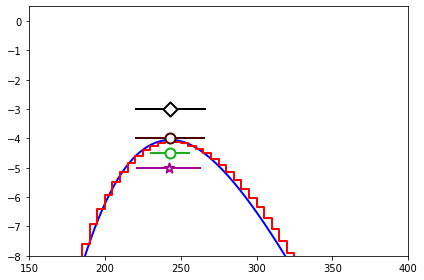

SR_S_120
n = 328 (328)


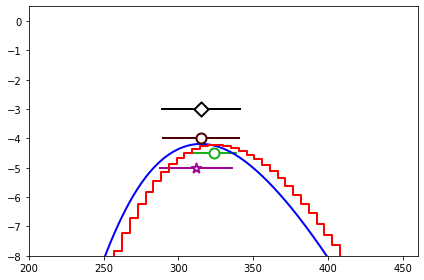

SR_S_130
n = 419 (419)


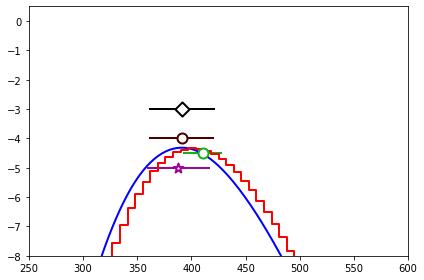

SR_S_140
n = 472 (472)


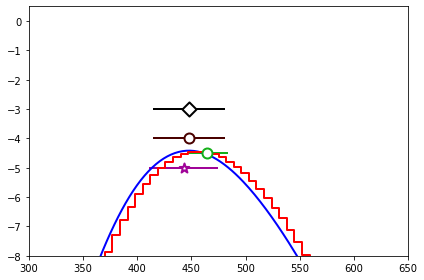

In [15]:
main("atlas_susy_compressed_2020")

# atlas_susy_DVmuon_2020
SRMET
n = 0 (0)


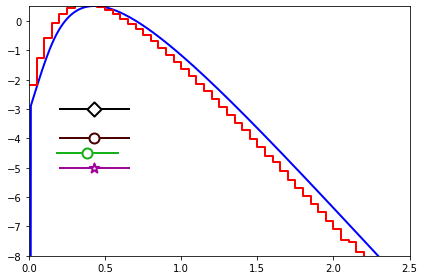

SRMU
n = 1 (1)


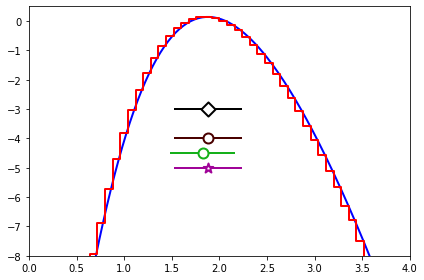

In [16]:
main("atlas_susy_DVmuon_2020")

# atlas_susy_hb_2019
SRA
n = 17 (17)


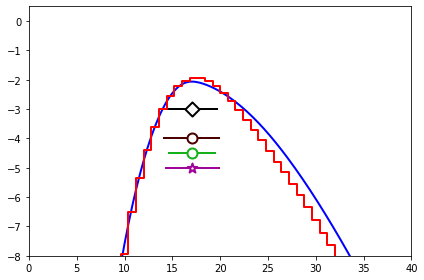

SRB
n = 3 (3)


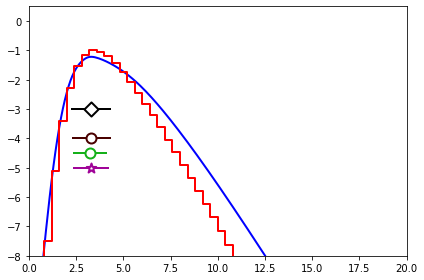

SRC
n = 47 (47)


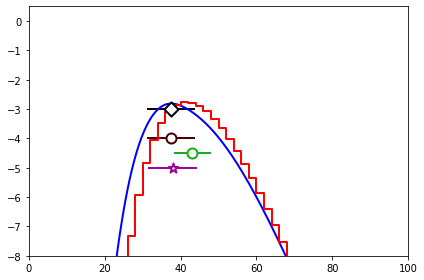

In [17]:
main("atlas_susy_hb_2019")

# atlas_susy_jets_2021
BDT-GGd1
n = 34 (34)


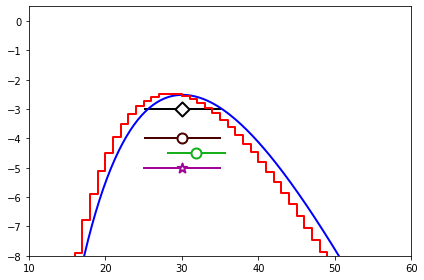

BDT-GGd2
n = 68 (68)


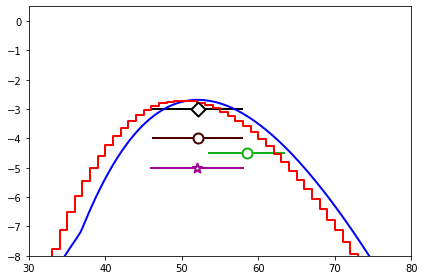

BDT-GGd3
n = 227 (227)


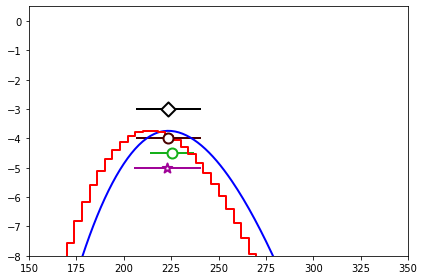

BDT-GGd4
n = 291 (291)


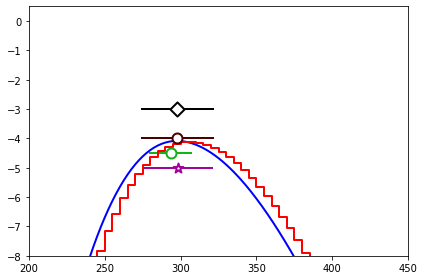

BDT-GGo1
n = 6 (6)


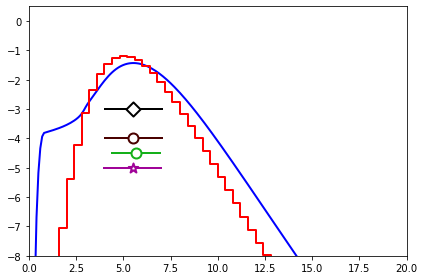

BDT-GGo2
n = 25 (25)


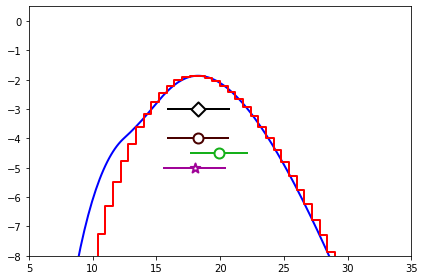

BDT-GGo3
n = 80 (80)


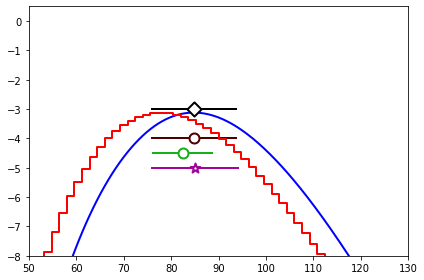

BDT-GGo4
n = 135 (135)


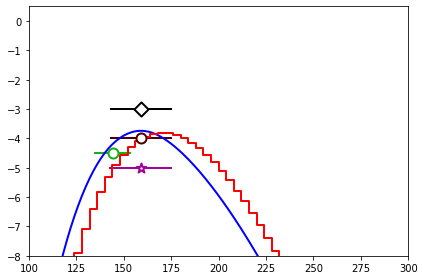

SR2j-1600
n = 2111 (2111)


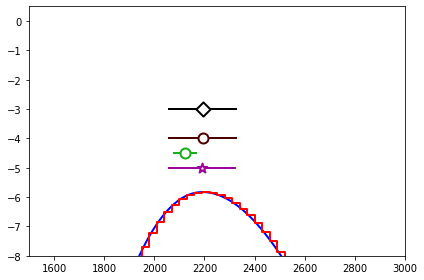

SR2j-2200
n = 971 (971)


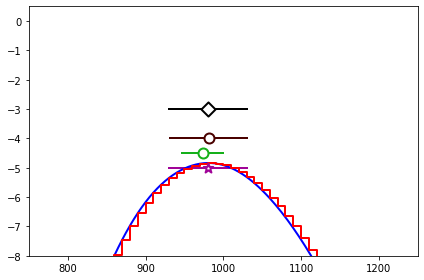

SR2j-2800
n = 78 (78)


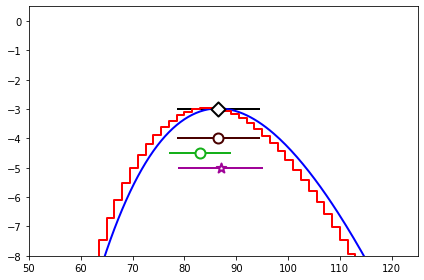

SR4j-1000
n = 535 (535)


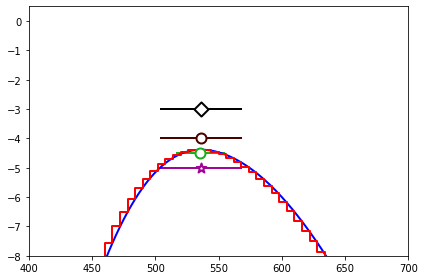

SR4j-2200
n = 60 (60)


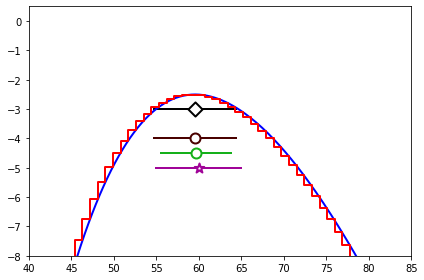

SR4j-3400
n = 4 (4)


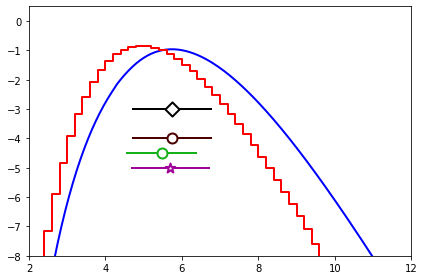

SR5j-1600
n = 320 (320)


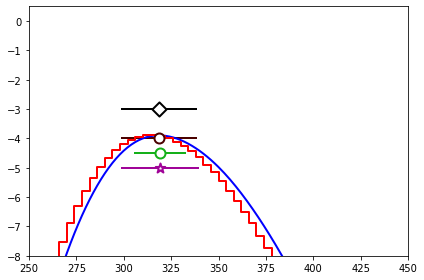

SR6j-1000
n = 25 (25)


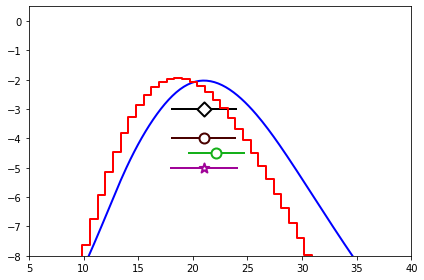

SR6j-2200
n = 5 (5)


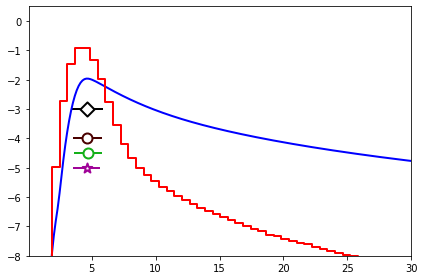

SR6j-3400
n = 0 (0)


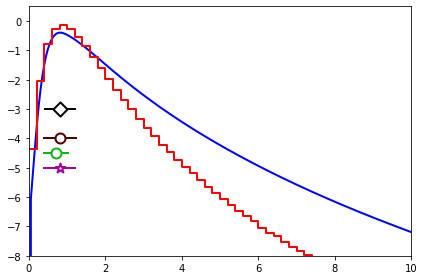

In [18]:
main("atlas_susy_jets_2021")